# 多层感知机实现

### 预备函数

In [19]:
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                   transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                   transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, 
                          num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, 
                          num_workers=get_dataloader_workers()))

def get_dataloader_workers():
    return 4

def accuracy(y_hat, y):
    """ 计算预测正确的数量 """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 至少有两个维度，第二个维度数量大于1（也就是不止1列）
        y_hat = y_hat.argmax(axis=1) # 选出每行最大的元素的下标，作为新的y_hat

    cmp = y_hat.type(y.dtype) == y # == 对数据类型敏感，所以对y_hat类型转化为y的类型
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 切换到评估模式，确保结果一致性
    metric = Accumulator(2) # 2 个元素的累加器
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # 不断累加预测正确的数量、总预测数量

    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """ 训练模型一个迭代周期 """
    if isinstance(net, torch.nn.Module):
        net.train() # 将模型设置为训练模式

    metric = Accumulator(3) # 训练损失总和、训练准确数总和、样本数
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y) # 先预测
        # 计算梯度并更新参数
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad() # 清除上一轮的旧梯度
            l.mean().backward() # 反向传播：计算当前梯度
            updater.step() # 参数更新：应用梯度更新权重
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

import matplotlib.pyplot as plt
from IPython import display

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 设置 SVG 显示
        plt.rcParams['figure.figsize'] = figsize
        plt.rcParams['svg.fonttype'] = 'none'  # 使 SVG 中的文本可编辑
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        else:
            self.axes = self.axes.flatten()
        
        # 配置坐标轴
        self.config_axes = lambda ax: self._set_axes(
            ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        
        self.X, self.Y, self.fmts = None, None, fmts
        self.legend = legend

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴属性"""
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        if legend:
            ax.legend(legend)
        ax.grid(True)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        # 初始化数据存储
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        
        # 添加数据点
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        # 清除并重新绘制
        self.axes[0].cla()
        for i, (x_data, y_data, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if x_data and y_data:  # 确保有数据可绘制
                self.axes[0].plot(x_data, y_data, fmt)
        
        # 配置坐标轴
        self.config_axes(self.axes[0])
        
        # 显示图形
        display.display(self.fig)
        display.clear_output(wait=True)

    def close(self):
        """关闭图形"""
        plt.close(self.fig)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    # 定义一个动画显示
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    # 检测
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


### 准备数据

In [15]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 实现一个单隐藏层的多层感知机

In [25]:
num_inputs, num_hiddens, num_outputs = 784, 256, 10

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
# 乘 0.01 是为了防止梯度爆炸

params = [W1, b1, W2, b2]

#### 实现ReLU函数

In [17]:
def ReLU(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

x = torch.tensor([2, -3.4])
ReLU(x)

tensor([2., 0.])

#### 定义网络

In [21]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = ReLU(X @ W1 + b1)
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()

#### 开始训练

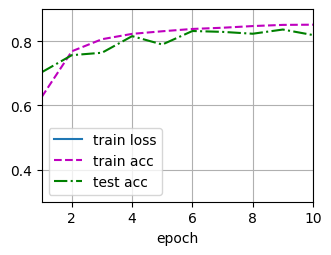

In [26]:
num_epochs, lr = 10, 0.07
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

# 多层感知机简洁实现

In [29]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

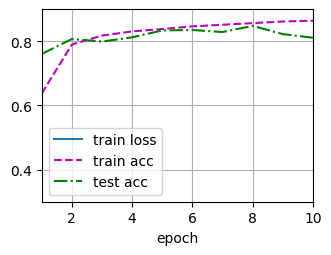

In [30]:
batch_size, lr, num_epochs = 256, 0.1, 10
train_iter, test_iter = load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)